# Assignment 4

The objective of this assignment is to introduce you to federated learning, with a particular focus on the challenges posed by data heterogeneity. Specifically, you will explore well-known approaches for addressing statistical heterogeneity, approaching the problem from multiple angles.

You have been provided with a manual that includes detailed descriptions of each task. Follow the instructions in the manual carefully, and add your answers and implementations directly in this notebook.

Note: In this assignment, we concentrate on one common type of statistical heterogeneity: label skew. While feature skew is another significant aspect of heterogeneity, it will not be the focus of this assignment.

In [1]:
import os
import torch
from torchvision import datasets, transforms
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Subset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Calculate sizes for training and testing datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Define fixed indices for train and test splits
train_indices = list(range(train_size))
test_indices = list(range(train_size, len(dataset)))

# Create Subsets based on these indices
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_images = dataset.data[train_dataset.indices].numpy()
train_labels = dataset.targets[train_dataset.indices].numpy()
test_images = dataset.data[test_dataset.indices].numpy()
test_labels = dataset.targets[test_dataset.indices].numpy()


In [4]:
def partition_data(train_data, train_targets, test_data, test_targets, num_clients, dirichlet_alpha=0.5, batch_size=32):
    num_classes = len(np.unique(train_targets))
    client_data_indices = defaultdict(list)
    client_test_indices = defaultdict(list)

    # Partition Train Data and Capture Proportions
    client_proportions = []
    for c in range(num_classes):
        class_indices = np.where(train_targets == c)[0]
        proportions = np.random.dirichlet([dirichlet_alpha] * num_clients)
        client_proportions.append(proportions)

        # Calculate split sizes and assign indices to each client
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_data_indices[i].extend(indices)

    # Partition Test Data Using the Same Proportions as Train Data
    for c, proportions in enumerate(client_proportions):
        class_indices = np.where(test_targets == c)[0]
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_test_indices[i].extend(indices)

    # Create Federated Loaders
    federated_train_loaders, federated_test_loaders = [], []
    for i in range(num_clients):
        client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_train_targets = torch.tensor(train_targets[client_data_indices[i]], dtype=torch.long)
        train_loader = DataLoader(TensorDataset(client_train_data, client_train_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_train_loaders.append(train_loader)

        client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_test_targets = torch.tensor(test_targets[client_test_indices[i]], dtype=torch.long)
        test_loader = DataLoader(TensorDataset(client_test_data, client_test_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_test_loaders.append(test_loader)

    # Create Centralized Loader by combining data from federated loaders
    centralized_data, centralized_targets = [], []
    for train_loader in federated_train_loaders:
        for images, targets in train_loader:
            centralized_data.append(images)
            centralized_targets.append(targets)
    
    centralized_data = torch.cat(centralized_data)
    centralized_targets = torch.cat(centralized_targets)
    train_centralized_loader = DataLoader(TensorDataset(centralized_data, centralized_targets), batch_size=batch_size, shuffle=False, drop_last=False)

    centralized_test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)
    centralized_test_targets = torch.tensor(test_targets, dtype=torch.long)
    test_centralized_loader = DataLoader(TensorDataset(centralized_test_data, centralized_test_targets), batch_size=batch_size, shuffle=False)

    return federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader


In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500,10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Task 2: FedAvg

Implement the fedavg_training function to perform Federated Averaging (FedAvg) over multiple communication rounds. Each round, collect updates from clients by training locally on their data and average these updates to form a new global model.

Additionally, implement the local_train function to handle client-side training. You are not restricted to using full-batch gradient descent; feel free to use mini-batch gradient descent instead. Make sure your implementation aligns with the provided code to plot the accuracies, as you should not modify that code.

In [6]:
def evaluate_model(global_model, test_loaders):
    global_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)

    client_accuracies = []
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for client_id, test_loader in enumerate(test_loaders):
            client_correct, client_total = 0, 0
            print(f"\nEvaluating Client {client_id}")

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = global_model(images)
                _, predicted = torch.max(outputs, 1)

                client_correct += (predicted == labels).sum().item()
                client_total += labels.size(0)

            client_accuracy = (client_correct / client_total) * 100
            client_accuracies.append(client_accuracy)

            print(f"Client {client_id} Accuracy: {client_accuracy:.2f}%")

            total_correct += client_correct
            total_samples += client_total

    total_accuracy = (total_correct / total_samples) * 100
    print(f"Total Accuracy: {total_accuracy:.2f}%")
    return client_accuracies, total_accuracy



In [17]:
import time
import torch
import torch.nn as nn

def local_train(model, train_loader, epochs, lr):
    device = torch.device("mps" if torch.backends.mps.is_available() 
                          else "cuda" if torch.cuda.is_available() 
                          else "cpu")
    
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        start_time = time.time()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch + 1}/{epochs} completed in {epoch_time:.2f} seconds.")
    return {name: param.clone().detach() for name, param in model.state_dict().items()}


def fedavg_training(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    
    device = torch.device("mps" if torch.backends.mps.is_available() 
                          else "cuda" if torch.cuda.is_available() 
                          else "cpu")
    
    global_model.to(device)
    global_model.train()

    round_avg_updates = []
    round_accuracies = []

    for round in range(rounds):
        round_start_time = time.time()
        print(f"\nRound {round + 1}/{rounds}")
        client_updates = []

        for client_id, train_loader in enumerate(train_loaders):
            print(f"  Client {client_id + 1}/{len(train_loaders)}")
            local_model = SimpleCNN()
            local_model.load_state_dict(global_model.state_dict())  

            local_update = local_train(local_model, train_loader, epochs, lr)
            client_updates.append(local_update)

        avg_update = {name: sum(client_update[name] for client_update in client_updates) / num_clients
                      for name in client_updates[0]}
        round_avg_updates.append(avg_update)
        global_model.load_state_dict(avg_update)

        _, total_accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(total_accuracy)

        round_time = time.time() - round_start_time
        print(f"Round {round + 1}/{rounds} completed in {round_time:.2f} seconds.")

    return round_avg_updates, round_accuracies


In the following code you may change the learning rate or the batch size

In [18]:
# Parameters
num_clients = 5
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001
dirichlet_alphas = [2, 0.5, 0.1]

def run_fedavg(alpha):
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_fedavg = SimpleCNN()
    _, round_accuracies = fedavg_training(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    return round_accuracies

accuracies_per_alpha = []

for alpha in dirichlet_alphas:
    round_accuracies = run_fedavg(alpha)
    accuracies_per_alpha.append(round_accuracies)



Round 1/3
  Client 1/5
Epoch 1/20 completed in 3.21 seconds.
Epoch 2/20 completed in 0.53 seconds.
Epoch 3/20 completed in 0.65 seconds.
Epoch 4/20 completed in 0.48 seconds.
Epoch 5/20 completed in 0.59 seconds.
Epoch 6/20 completed in 0.55 seconds.
Epoch 7/20 completed in 0.56 seconds.
Epoch 8/20 completed in 0.57 seconds.
Epoch 9/20 completed in 0.46 seconds.
Epoch 10/20 completed in 0.48 seconds.
Epoch 11/20 completed in 0.57 seconds.
Epoch 12/20 completed in 0.63 seconds.
Epoch 13/20 completed in 0.61 seconds.
Epoch 14/20 completed in 0.59 seconds.
Epoch 15/20 completed in 0.50 seconds.
Epoch 16/20 completed in 0.60 seconds.
Epoch 17/20 completed in 0.45 seconds.
Epoch 18/20 completed in 0.53 seconds.
Epoch 19/20 completed in 0.58 seconds.
Epoch 20/20 completed in 0.64 seconds.
  Client 2/5
Epoch 1/20 completed in 1.28 seconds.
Epoch 2/20 completed in 0.52 seconds.
Epoch 3/20 completed in 0.60 seconds.
Epoch 4/20 completed in 0.61 seconds.
Epoch 5/20 completed in 0.58 seconds.
Ep

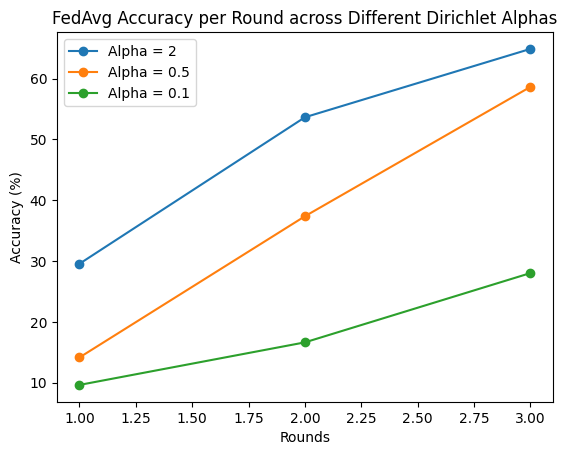

In [19]:
# Plotting accuracy per round for each alpha value
plt.figure()
for idx, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), accuracies_per_alpha[idx], marker='o', label=f'Alpha = {alpha}')

plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('FedAvg Accuracy per Round across Different Dirichlet Alphas')
plt.show()